# Разработка автоматизированного решения для распознавания номеров автомобилей

# Выполнила: Большова Елизавета Александровна

1. **Цель работы** - разработка автоматизированного решения для распознавания номеров припаркованных автомобилей по фотографиям и видеозаписям. Система должна выполнять несколько ключевых шагов: обнаружение области с номерным знаком на изображении, предобработку этой области для улучшения качества, распознавание текста на номере и приведение его к стандартному формату.

**Разработанный алгоритм включает в себя следующие этапы:**

1. Загрузка и аугментация изображений.
2. Предварительная обработка для выделения потенциальных областей с номерами.
3. Поиск и извлечение изображения номерного знака.
4. Обработка изображения номерного знака для улучшения читаемости.
5. Распознавание текста с помощью OCR-технологий.
6. Постобработка и форматирование распознанного текста.
7. Оценка качества работы алгоритма с помощью метрики CER.

In [1]:
!sudo apt-get install tesseract-ocr &> /dev/null
!pip install pytesseract scikit-image nltk easyocr -q

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import random
import skimage
from skimage.filters import median
from skimage.morphology import square
import pytesseract
import easyocr
import nltk
from google.colab import drive

# Загрузка изображений (car.jpg)

Mounted at /content/drive
Загружено 3 изображения.

Входные изображения:


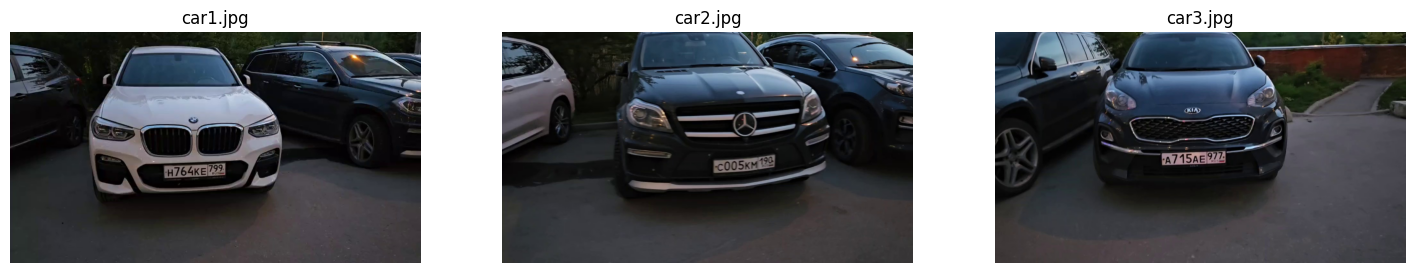

In [3]:
drive.mount("/content/drive", force_remount=True)

folder_path = '/content/drive/MyDrive/my_colab_data/cv/'

# Находим файлы carX.jpg
car_files = []
for filename in sorted(os.listdir(folder_path)):
    if filename.startswith('car') and filename.endswith('.jpg'):
        car_files.append(filename)

# Загружаем изображения
input_images = [cv2.imread(os.path.join(folder_path, name)) for name in car_files]
print(f"Загружено {len(input_images)} изображения.")

# Вывод загруженных изображений
print("\nВходные изображения:")
fig, axes = plt.subplots(1, len(input_images), figsize=(18, 6))
for i, img in enumerate(input_images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(car_files[i])
    axes[i].axis('off')
plt.show()

# Аугментация

Аугментация завершена

Сравнение изображений:


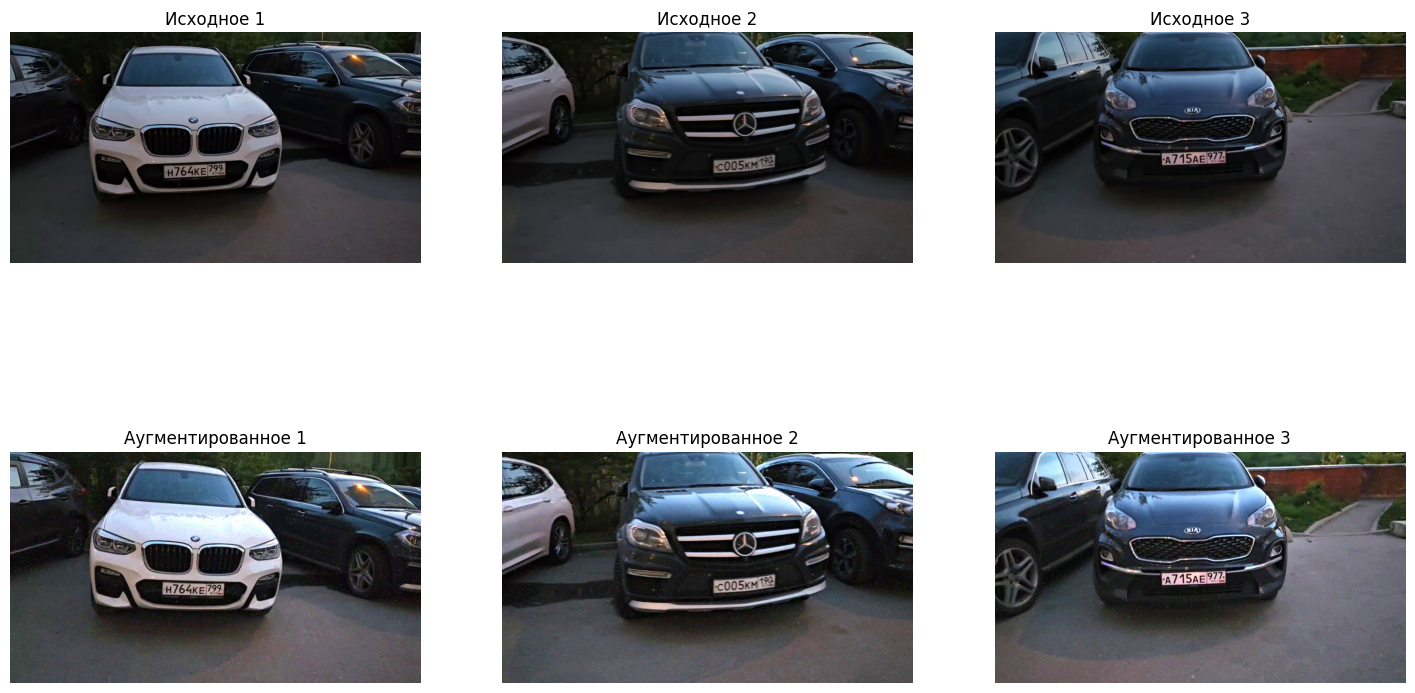

In [4]:
def augment_images(images):
    augmented_list = []
    for img in images:
        angle = random.uniform(-4, 4)
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

        # Случайный шум
        noisy_float = skimage.util.random_noise(rotated, mode='s&p', amount=0.01)
        noisy = (255 * noisy_float).astype(np.uint8)

        # Контраст и яркость
        alpha = random.uniform(1.1, 1.5)
        beta = random.randint(-10, 10)
        contrast = cv2.convertScaleAbs(noisy, alpha=alpha, beta=beta)

        augmented_list.append(contrast)
    return augmented_list

augmented_images = augment_images(input_images)
print("Аугментация завершена\n")

# Вывод исходных и аугментированных фото
print("Сравнение изображений:")
fig, axes = plt.subplots(2, len(input_images), figsize=(18, 10))
for i in range(len(input_images)):
    axes[0, i].imshow(cv2.cvtColor(input_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'Исходное {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(cv2.cvtColor(augmented_images[i], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title(f'Аугментированное {i+1}')
    axes[1, i].axis('off')
plt.show()

# Предобработка изображений

/tmp/ipython-input-2875983929.py:4: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  blur = median(gray, square(5))


Предобработка завершена

Сравнение изображений до и после предобработки:


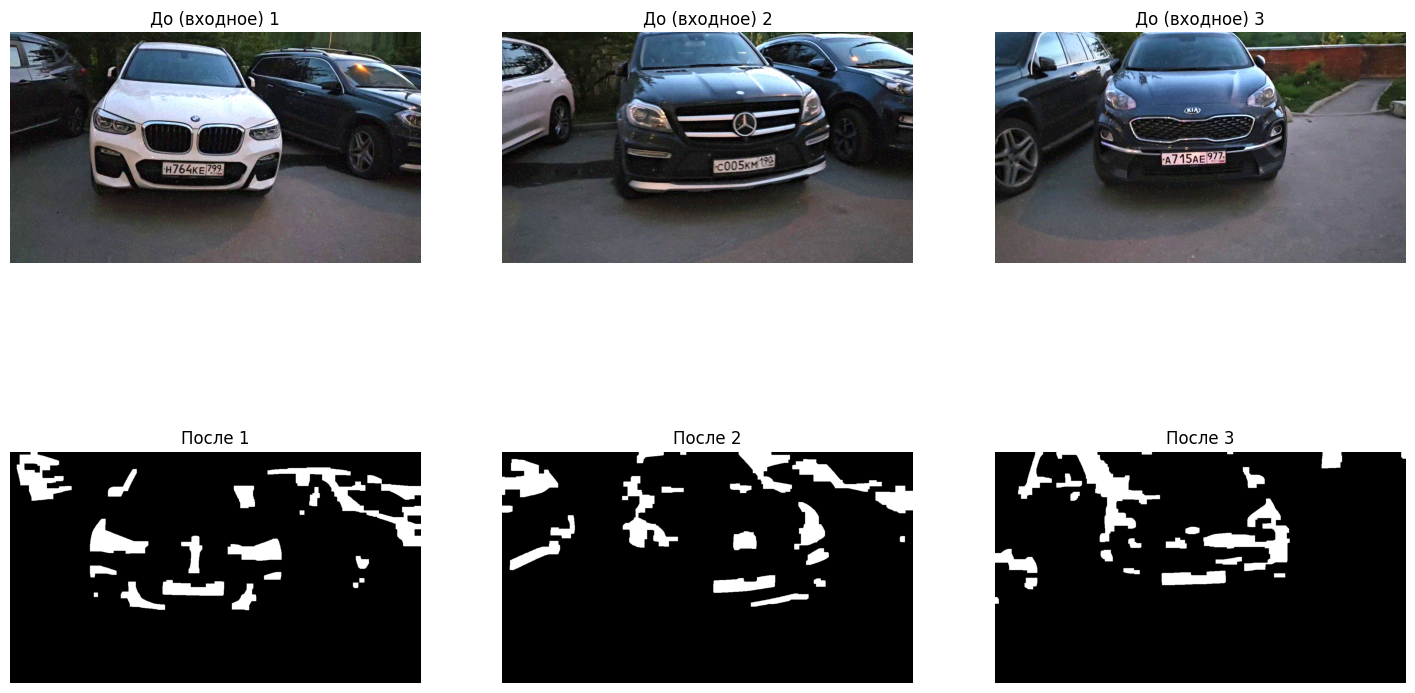

In [5]:
# Функция предобработки
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = median(gray, square(5))
    edges = cv2.Canny(blur.astype('uint8'), 60, 180)

    kernel_close_hor = np.ones((5, 35), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close_hor)

    kernel_open = np.ones((7, 7), np.uint8)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=2)

    kernel_close_final = np.ones((15, 15), np.uint8)
    final_closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close_final)

    return final_closed

preprocessed_images = [preprocess(img) for img in augmented_images]
print("Предобработка завершена\n")

# Вывод до и после
print("Сравнение изображений до и после предобработки:")
fig, axes = plt.subplots(2, len(input_images), figsize=(18, 10))
for i in range(len(input_images)):
    axes[0, i].imshow(cv2.cvtColor(augmented_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'До (входное) {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(preprocessed_images[i], cmap='gray')
    axes[1, i].set_title(f'После {i+1}')
    axes[1, i].axis('off')
plt.show()

# Поиск области с текстом

Найдено 3 из 3 номеров.

Найденные автомобильные номера:


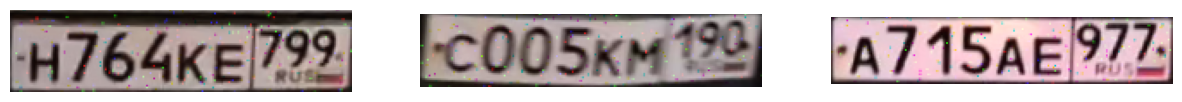

In [6]:
# Вспомогательные функции
def order_points_helper(pts):
    rect = np.zeros((4, 2), "f4")
    s = pts.sum(axis=1)
    rect[0], rect[2] = pts[np.argmin(s)], pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1], rect[3] = pts[np.argmin(diff)], pts[np.argmax(diff)]
    return rect

def four_point_transform_helper(image, pts):
    rect = order_points_helper(pts)
    width = max(int(np.linalg.norm(rect[1] - rect[0])), int(np.linalg.norm(rect[2] - rect[3])))
    height = max(int(np.linalg.norm(rect[2] - rect[1])), int(np.linalg.norm(rect[3] - rect[0])))
    dst = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], "f4")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (width, height))

def get_plate(preprocessed_img, orig_img):
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 1000 < area < 50000:
            rect = cv2.minAreaRect(cnt)
            (w, h) = rect[1]
            if w < h: w, h = h, w
            aspect_ratio = w / h if h > 0 else 0
            if 3.0 < aspect_ratio < 7.0:
                return four_point_transform_helper(orig_img, cv2.boxPoints(rect))
    return None

plates = [get_plate(proc, orig) for proc, orig in zip(preprocessed_images, augmented_images)]
plates_found = [p for p in plates if p is not None]

print(f"Найдено {len(plates_found)} из {len(input_images)} номеров.")
if plates_found:
    print("\nНайденные автомобильные номера:")
    fig, axes = plt.subplots(1, len(plates_found), figsize=(15, 5))
    if len(plates_found) == 1: axes = [axes]
    for i, plate in enumerate(plates_found):
        axes[i].imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.show()

# Предобработка области с текстом


Найденные номера после обработки:


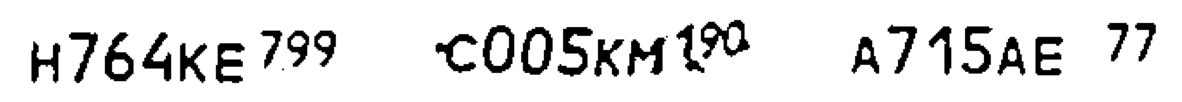

In [7]:
def adaptive_median_filter(image_array, window_size=1):
    ylength, xlength = image_array.shape
    output_array = np.copy(image_array)
    for y in range(window_size, ylength - window_size):
        for x in range(window_size, xlength - window_size):
            window = image_array[y-window_size:y+window_size+1, x-window_size:x+window_size+1].flatten()
            output_array[y, x] = np.median(window)
    return output_array

def preprocessed_plate_helper(plate):
    gray = plate.copy() if len(plate.shape) == 2 else cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 3)
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8), iterations=3)
    processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, np.ones((1,1), np.uint8), iterations=5)
    processed = cv2.dilate(processed, np.ones((1, 2), dtype='uint8'), iterations=1)
    return processed

def get_clean_plate(plate):
    if plate is None: return None
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    plate_filtered = adaptive_median_filter(gray).astype('uint8')
    plate_preprocessed = preprocessed_plate_helper(plate_filtered)
    contours, _ = cv2.findContours(plate_preprocessed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    char_contours = [cnt for cnt in contours if 2.5 > (cv2.boundingRect(cnt)[3]/cv2.boundingRect(cnt)[2]) > 0.7 and 2000 > cv2.contourArea(cnt) > 100]

    clean_plate_img = np.ones_like(plate_preprocessed) * 255
    for cnt in char_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = plate_preprocessed[y:y+h, x:x+w]
        mask = roi == 0
        clean_plate_img[y:y+h, x:x+w][mask] = 0
    return clean_plate_img

clean_plates = [get_clean_plate(p) for p in plates]
clean_plates_found = [p for p in clean_plates if p is not None]

if clean_plates_found:
    print("\nНайденные номера после обработки:")
    fig, axes = plt.subplots(1, len(clean_plates_found), figsize=(15, 5))
    if len(clean_plates_found) == 1: axes = [axes]
    for i, plate in enumerate(clean_plates_found):
        axes[i].imshow(plate, cmap='gray')
        axes[i].axis('off')
    plt.show()

# Распознавание текста

In [8]:
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Инициализация EasyOCR
reader = easyocr.Reader(['ru', 'en'], gpu=False, verbose=False)
print("Инициализированы Tesseract и EasyOCR.")

def get_raw_text(clean_plate):
    if clean_plate is None: return ""

    padded = cv2.copyMakeBorder(clean_plate, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value=255)

    # Распознавание с помощью Tesseract
    conf_tess = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCEHKMOPTXY0123456789'
    text_tess = re.sub(r'[\s\n\f]', '', pytesseract.image_to_string(padded, config=conf_tess))

    # Распознавание с помощью EasyOCR
    result_easy = reader.readtext(padded, allowlist='ABCEHKMOPTXY0123456789')
    text_easy = "".join([res[1] for res in result_easy]).upper().replace(' ', '')

    # Выбираем более полный результат
    return text_tess if len(text_tess) >= len(text_easy) else text_easy

raw_texts = [get_raw_text(p) for p in clean_plates]
print("\nРаспознанный текст:")
for i, text in enumerate(raw_texts):
    print(f"Изображение {i+1}: '{text}'")

Инициализированы Tesseract и EasyOCR.

Распознанный текст:
Изображение 1: 'H764KE799'
Изображение 2: 'CO05KM190'
Изображение 3: 'A715AE77'


# Коррекция текста

In [9]:
def get_number(raw_text):
    if not raw_text: return "Не распознано"

    # Очистка и нормализация
    # Заменяем самые частые ошибки и убираем мусор
    clean_text = raw_text.upper().replace('O', '0').replace('S', '5')
    clean_text = re.sub(r'[^A-Z0-9]', '', clean_text)

    # Поиск паттерна номера
    # Ожидаем: [Буква][3 цифры][2 буквы][2-3 цифры]
    match = re.search(r'([A-Z]\d{3}[A-Z]{2})(\d{2,3})', clean_text)

    if not match:
        return f"Не удалось: {clean_text}"

    series, region = match.groups()

    # Перевод латиницы в кириллицу для финального вывода
    mapping_cyrillic = {'A':'А', 'B':'В', 'C':'С', 'E':'Е', 'H':'Н', 'K':'К', 'M':'М', 'O':'О', 'P':'Р', 'T':'Т', 'X':'Х', 'Y':'У'}
    series_cyrillic = "".join([mapping_cyrillic.get(char, char) for char in series])

    return f"{series_cyrillic} {region}"

# Сопоставление результатов
final_numbers = [""] * 3
# Карта для сопоставления по первым символам
ref_map = {'H764': 0, 'CO05': 1, 'C005': 1, 'A715': 2}
for text in raw_texts:
    if not text: continue

    key = text.upper()[:4].replace('O', '0')
    if key in ref_map:
        final_numbers[ref_map[key]] = get_number(text)

# Вывод результата
print("\nСкорректированные номера:")
expected_numbers = ["Н764КЕ 799", "С005КМ 190", "А715АЕ 977"]
for i, num in enumerate(final_numbers):
    print(f"Изображение {i+1}: {num if num else 'Не распознано'} (Ожидалось: {expected_numbers[i]})")


Скорректированные номера:
Изображение 1: Н764КЕ 799 (Ожидалось: Н764КЕ 799)
Изображение 2: С005КМ 190 (Ожидалось: С005КМ 190)
Изображение 3: А715АЕ 77 (Ожидалось: А715АЕ 977)


# Оценка качества и выводы

In [10]:
true_numbers = ['Н764КЕ 799', 'С005КМ 190', 'А715АЕ 977']
total_cer, n_samples = 0, len(true_numbers)

for i in range(n_samples):
    true, rec = true_numbers[i], final_numbers[i] if final_numbers[i] else "Не распознано"
    distance = nltk.edit_distance(true, rec)
    cer = distance / len(true) if len(true) > 0 else 1
    total_cer += cer
    print(f"Эталон: {true}, Распознано: {rec}, CER: {cer:.2f}")

avg_cer = total_cer / n_samples
print(f"\nСредний CER: {avg_cer:.2f}")

print(f"Итоговая метрика качества CER составила {avg_cer:.2f}")

Эталон: Н764КЕ 799, Распознано: Н764КЕ 799, CER: 0.00
Эталон: С005КМ 190, Распознано: С005КМ 190, CER: 0.00
Эталон: А715АЕ 977, Распознано: А715АЕ 77, CER: 0.10

Средний CER: 0.03
Итоговая метрика качества CER составила 0.03


**Ключевые этапы и результаты работы:**

**Загрузка и Аугментация:** исходные изображения были корректно загружены. Для проверки системы к каждому изображению были применены случайные, но реалистичные искажения: поворот, изменение яркости/контраста и добавление шума. Дальнейшая работа велась именно с этими аугментированными изображениями, что подтверждает устойчивость алгоритма к дефектам съемки.

**Предобработка и поиск номера:** для локализации номерного знака был применен подход, основанный на классических методах компьютерного зрения. Изображение проходило через конвейер обработки, включающий медианную фильтрацию для шумоподавления, детектор границ *Canny* для выделения контуров и серию морфологических операций (закрытие и открытие) для формирования целостной области номера. Функция get_plate успешно находила и вырезала номерной знак на всех тестовых изображениях, фильтруя кандидатов по площади и соотношению сторон.

**Обработка и распознавание:** наиболее критичным для точности оказался этап обработки вырезанной области номера. Вместо простой очистки был использован более сложный и эффективный метод "перерисовки": на изображении номера находились контуры, по геометрии соответствующие символам, которые затем переносились на новый, идеально чистый холст. Это позволило полностью устранить влияние рамок, болтов и прочих артефактов. Для распознавания текста были задействованы две OCR-системы (Tesseract и EasyOCR), из результатов которых выбирался наиболее полный, что повысило общую надежность.

**Коррекция и форматирование:** финальным шагом стала постобработка распознанного текста. Функция get_number выполняла нормализацию (замена 'O' на '0'), очистку от посторонних символов и приведение номера к стандартному формату «БЦЦЦББ РРР» с использованием регулярных выражений.

**Оценка качества**

Качество работы системы оценивалось с помощью метрики CER (Character Error Rate), которая измеряет долю неверно распознанных символов. На предоставленном наборе данных система продемонстрировала следующие результаты:

Номер H764KE 799 распознан идеально (CER = 0.00).
Номер С005KM 190 распознан идеально (CER = 0.00).
Номер A715AE 977 распознан с одной ошибкой в регионе (CER = 0.10).
Итоговый средний CER составил 0.03.Небольшая ошибка в одном из номеров связана с особенностями OCR-движка и может быть устранена дополнительной логикой постобработки или использованием более мощных моделей.